In [2]:
%load_ext line_profiler

In [3]:
import sys
import numpy as np
import igraph as ig
import time
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from mpl_settings_v3 import *

from functions import powerlaw, edgelist_to_nn_set
from functions import get_CI, create_CI_struct, update_ci
from functions import ID_attack, RD_attack, ICI_attack, RCI_attack

In [4]:
N_values = [4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000, 2048000]
#N_values = [int(1e4), int(1e5), int(1e6), int(1e7)]
meank = 3.5
edgelists = {}
for N in N_values:
    p = meank / N
    g = ig.Graph().Erdos_Renyi(N, p)
    edgelist = []
    for e in g.es():
        edgelist.append(e.tuple)
        
    edgelists[N] = edgelist

In [4]:
N = 128000
nn_set = edgelist_to_nn_set(edgelists[N])
deg_seq = [len(s) for s in nn_set]
CI_seq = get_CI(nn_set, l=1)
v = 0
w = list(nn_set[v])[0]
print(v, w)

0 79634


In [5]:
#%lprun -f get_CI get_CI(nn_set, l=1)
#%lprun -f RCI_attack RCI_attack(nn_set, l=1)
%lprun -f RCI_attack RCI_attack(nn_set, l=1)
#%lprun -f create_CI_struct create_CI_struct(nn_set, l=1)
#%lprun -f update_ci update_ci(v, w, nn_set, deg_seq, CI_seq)
%lprun -f RD_attack RD_attack(nn_set)

Timer unit: 1e-06 s

Total time: 1.25607 s
File: /home/nahuel/algorithms/functions.py
Function: RD_attack at line 179

Line #      Hits         Time  Per Hit   % Time  Line Contents
   179                                           def RD_attack(nn_set):
   180                                               """
   181                                               Attack based on Recalculated Degree centrality.
   182                                               Complexity: O(N)
   183                                           
   184                                               Arguments:
   185                                                   nn_set {list} -- List of neighor sets for each node
   186                                           
   187                                               Returns:
   188                                                   list -- Order in which the nodes have been removed
   189                                               """
   190            

In [5]:
def attack_network(nn_set, attack):
    if attack == 'ID':
        order = ID_attack(nn_set)
    if attack == 'RD':
        order = RD_attack(nn_set)
    if attack == 'ICI':
        order = ICI_attack(nn_set, l=1)
    if attack == 'RCI':
        order = RCI_attack(nn_set, l=1)
    return order

attacks = ['ID', 'RD', 'ICI', 'RCI']
t_values_dict = {}

iterations = 10
for attack in attacks:
    print(attack)
    
    t_values = []
    for N, edgelist in edgelists.items():
        print(N)
        #if N > 1024000:
        #    t_values.append(np.NaN)
        #    continue

        nn_set = edgelist_to_nn_set(edgelist)

        t_per_it = np.zeros(iterations)
        for i in range(iterations):
            start = time.time()
            order = attack_network(nn_set, attack)
            t = time.time() - start
            t_per_it[i] = t
        t_values.append(t_per_it.mean())
    t_values_dict[attack] = t_values

ID
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000
RD
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000
ICI
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000
RCI
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000


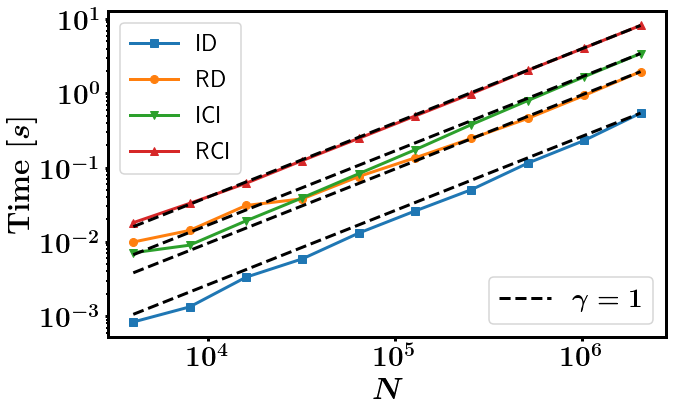

In [6]:
X = np.array(N_values)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\mathrm{Time}\;[s]$')

for i, (attack, t_values) in enumerate(t_values_dict.items()):
    ax.plot(N_values, t_values, '-', marker=markers[i], markersize=8, label=attack)
    
for i, (attack, t_values) in enumerate(t_values_dict.items()):
    c = t_values[-1] / N_values[-1]
    Y = powerlaw(X, 1, c)
    if i == 0:
        label = r'$\gamma = 1$'
    else:
        label = ''
    ax.plot(X, Y, '--', color='k', label=label)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

first_legend = ax.legend(handles=handles[:-1], loc='upper left', fontsize=24)
ax2 = ax.add_artist(first_legend)
ax.legend(handles=handles[-1:], loc='lower right')
plt.show()